(Cannibalized from `magenta/magenta/models/sketch_rnn/sketch_rnn.ipynb`)

In [1]:
# import the required libraries
import numpy as np
import time
import random
import cPickle
import codecs
import collections
import os
import math
import json
import tensorflow as tf
from six.moves import xrange

# libraries required for visualisation:
from IPython.display import SVG, display
import svgwrite # conda install -c omnia svgwrite=1.1.6
import PIL
from PIL import Image
import matplotlib.pyplot as plt

import pandas as pd

# set numpy output to something sensible
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)

tf.logging.info("TensorFlow Version: %s", tf.__version__)

from magenta.models.sketch_rnn import sketch_rnn_train as train
# (Cause I wanna use 'model' as a variable name)
from magenta.models.sketch_rnn import model as models
from magenta.models.sketch_rnn import utils
from magenta.models.sketch_rnn import rnn

import transfiguration as transfig

from notebook_helpers import make_grid_svg, draw_strokes
import notebook_helpers as nbhelpers

%matplotlib inline

INFO:tensorflow:TensorFlow Version: 1.1.0


In [2]:
#domain = 'owl'
domain = 'flamingo'
picklepath = '{}s.pickle'.format(domain)
load_saved = 1
if load_saved:
    df = pd.read_pickle(picklepath)
else:
    df = None
save = not load_saved
truncated_size = 0
models_root = 'models'
assert domain in ('owl', 'flamingo')
conditional = domain == 'owl'
subdir = 'lstm' + ('_uncond' if not conditional else '')
model_dir = os.path.join(models_root, domain, subdir)
data_root = 'data'
# The default npz files have 75k instances each. There are also '.full.npz' files
# which have more, I guess.
full = 1
data_fname = 'sketchrnn-{}.{}npz'.format(domain, 'full.' if full else '')
data_path = os.path.join(data_root, data_fname)

model_params = models.get_default_hparams()
with tf.gfile.Open(os.path.join(model_dir, 'model_config.json'), 'r') as f:
    model_config = json.load(f)
    model_params.update(model_config)

In [3]:
hps = model_params
#hps.batch_size = 1
print "Using batch size = {}".format(hps.batch_size)
hps.use_input_dropout = 0
hps.use_recurrent_dropout = 0
hps.use_output_dropout = 0
hps.is_training = 0
print "max_seq_len = {}".format(hps.max_seq_len)
# TODO: the sample loading code in sketch_rnn_train forces 
# max_seq_len to the maximum in the dataset. Not sure what
# advantage there is to this? Going to leave it alone for now
# (in the case of flamingos, model_config.json sets max len
# to 105, whereas the max in the data is 91. Which is weird.)

# ??? necessary?
#train.reset_graph()
model = models.Model(hps)
sample_hps = models.copy_hparams(hps)
sample_hps.batch_size = 1
sample_hps.max_seq_len = 1 # sample one point at a time
sample_model = models.Model(sample_hps, reuse=True)
eval_hps = models.copy_hparams(sample_hps)
eval_hps.max_seq_len = hps.max_seq_len
eval_model = models.Model(eval_hps, reuse=True)

Using batch size = 100
max_seq_len = 105
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.
hello tensorflow!
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.
hello tensorflow!
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.
hello tensorflow!


In [4]:
%%time
def load_dataset(path):
    dat = np.load(path)
    keys = ['train', 'valid', 'test']
    assert set(dat.files) == set(keys)
    # We don't care about the train/test/val split for the present 
    # purpose, so just glom them all together
    strokes = np.concatenate([dat[k] for k in keys])
    print "Loaded stroke data having shape {}".format(strokes.shape)
    return strokes

def load_domain(dom):
    fname = 'sketchrnn-{}.npz'.format(dom)
    path = os.path.join(data_root, data_fname)
    return load_dataset(path)
    

rawdat = load_dataset(data_path)
if truncated_size and not load_saved:
    orig = rawdat.shape[0]
    rawdat = rawdat[:truncated_size]
    print 'Truncated from {} instances to {}'.format(orig, truncated_size)
dataset = utils.DataLoader(rawdat, 
                           batch_size=hps.batch_size,
                           max_seq_length=hps.max_seq_len
                          )
dataset.normalize()

Loaded stroke data having shape (112708,)
total images <= max_seq_len is 112708
CPU times: user 14.9 s, sys: 308 ms, total: 15.2 s
Wall time: 15.1 s


In [5]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# loads the weights from checkpoint into our model
train.load_checkpoint(sess, model_dir)

INFO:tensorflow:Loading model models/flamingo/lstm_uncond/vector.
INFO:tensorflow:Restoring parameters from models/flamingo/lstm_uncond/vector


In [327]:
def _get_perplexities(sketches, model):
    # This is a silly naive approach but let's see how it goes.
    n = len(sketches)
    ppxs = np.zeros(n)
    for i, raw_strokes in enumerate(sketches):
        strokes = ([[0, 0, 1, 0, 0]] + 
                   utils.to_big_strokes(raw_strokes, max_len=model.hps.max_seq_len).tolist()
                  )
        fd = {model.input_data: [strokes], 
              model.sequence_lengths: [len(raw_strokes)]
             }
        loss = sess.run(model.r_cost, feed_dict=fd)
        ppxs[i] = -loss
    return ppxs

LOG_EVERY = 5000

def get_perplexities(dat, model, normalize=False):
    n = len(dat.strokes)
    batchsize = dat.batch_size
    ppxs = np.zeros(n)
    for ibatch in range(dat.num_batches):
        # we get batches in stroke-3 and stroke-5 fmt
        batch3, batch5, seqlens = dat.get_batch(ibatch)
        fd = {model.input_data: batch5, 
              model.sequence_lengths: seqlens
             }
        loss = sess.run(model.lossfunc, feed_dict=fd)
        # TODO: probably makes more sense not to flip sign. Kept it out of habit.
        if normalize:
            batch_ppx = loss.reshape(batchsize, -1).sum(axis=1)
            # normalize by lengths
            assert batch_ppx.shape == seqlens.shape
            batch_ppx /= seqlens
        else:
            batch_ppx = -1 * loss.reshape(batchsize, -1).mean(axis=1)
        ppxs[ibatch*batchsize:(ibatch+1)*batchsize] = batch_ppx
        
        ndone = (ibatch+1) * batchsize
        if ndone % LOG_EVERY == 0:
            print "...i = {}".format(ndone)
        
    return ppxs

def draw_top_n(ppxs, strokes, n=10, sign=1, rows=1, random=0, 
               grid_space=16.0, grid_space_x=24.0,
               fname='/tmp/sketch_rnn/svg/sample.svg',
               prefix=None,
               echo=True,
               factor=0.2,
               save=True,
               size=None,
              ):
    pivot = -1*sign*n
    if random:
        indices = np.random.randint(0, len(strokes), size=n)
    else:
        #indices = np.argpartition(ppxs, pivot)[::sign][-n:]
        #indices = indices[ppxs[indices].argsort()[::sign]]
        indices = np.argsort(ppxs)[::sign][-n:][::-1]
    
    if prefix is None and save:
        draw_sketches(strokes, indices, rows=rows, grid_space=grid_space, 
                      grid_space_x=grid_space_x, fname=fname, echo=echo)
    elif save:
        for rank, i in enumerate(indices):
            fname = 'svgs/single/{}_{}.svg'.format(prefix, rank)
            nbhelpers.draw_strokes(strokes[i], svg_filename=fname, echo=echo, factor=factor, size=size)
    return indices

def draw_sketches(strokes, indices, rows=1, cols=None, grid_space=16.0, grid_space_x=24.0,
                 fname='/tmp/sketch_rnn/svg/sample.svg',
                  echo=True, padx=25, pady=25,
                 ):
    if not isinstance(indices, list):
        assert len(indices.shape) == 1
        indices = list(indices)
    n = len(indices)
    if cols:
        per_row = cols
    else:
        per_row = n / rows
    to_draw = []
    for rank, i in enumerate(indices):
        posn = [rank / per_row, rank % per_row]
        to_draw.append(
            [strokes[i], posn]
        )
    grid = nbhelpers.make_grid_svg(to_draw, grid_space=grid_space, grid_space_x=grid_space_x)
    nbhelpers.draw_strokes(grid, svg_filename=fname, echo=echo, padx=padx, pady=pady)

In [7]:
%%time
if not load_saved:
    #lenfn = lambda arr: arr.shape[0]
    #lenify = np.vectorize(lenfn)
    #seqlens = lenify(rawdat)
    seqlens = map(lambda sk: len(sk), strokes)
    df = pd.DataFrame(seqlens, columns=['len'])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.2 µs


In [8]:
%%time
if not load_saved:
    # TODO: see if using a more aggressive max_seq_len speeds this up?
    ppx = get_perplexities(dataset, model)
    #ppx = _get_perplexities(dataset.strokes, model)
    assert ppx.shape[0] == df.shape[0]
    df['ppx'] = ppx
    print df['ppx'].describe()
    # TODO: compare to naive implementation, and profile
else:
    ppx = df['ppx']

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 229 µs


In [182]:
%%time
crazy = 0
if crazy:
    ppx_normalized = get_perplexities(dataset, model, normalize=True)
    df['ppxnorm'] = ppx_normalized

...i = 5000
...i = 10000
...i = 15000
...i = 20000
...i = 25000
...i = 30000
...i = 35000
...i = 40000
...i = 45000
...i = 50000
...i = 55000
...i = 60000
...i = 65000
...i = 70000
...i = 75000
...i = 80000
...i = 85000
...i = 90000
...i = 95000
...i = 100000
...i = 105000
...i = 110000
CPU times: user 1h 15min 42s, sys: 10min 27s, total: 1h 26min 10s
Wall time: 15min 32s


In [9]:
if not load_saved:
    pendowns = [sketch[:,2].sum() for sketch in strokes]
    df['pendowns'] = pendowns

In [19]:
inull = df['ppx'].isnull()
nnull = inull.sum()
if nnull:
    print "WARNING: 'dropping' {} rows with null ppx".format(nnull)
    # (actually just setting to 0 because of reasons)
    #df = df.dropna()
    df.loc[inull, 'ppx'] = 0
    ppx = df['ppx']

In [246]:
crazy = 0
if crazy:
    nnull = ppxnorm.isnull().sum()
    if nnull:
        print "Dropping {} null ppxnorm values".format(nnull)
        nullrows = df[ppxnorm.isnull()]
        inull = ppxnorm.isnull()
        df.loc[inull, 'ppxnorm'] = 0
        ppxnorm = df['ppxnorm']

Dropping 54 null ppxnorm values


In [10]:
save = 0
if save:
    df.to_pickle(picklepath)

In [11]:
def load_domain(dom):
    fname = 'sketchrnn-{}.npz'.format(dom)
    path = os.path.join(data_root, fname)
    return load_dataset(path)

rawflops = load_domain('floor lamp')
rawflops = rawflops[:2000]
flops = utils.DataLoader(rawflops, 
                           batch_size=hps.batch_size,
                           max_seq_length=hps.max_seq_len
                          )
flops.normalize()


Loaded stroke data having shape (75000,)
total images <= max_seq_len is 2000


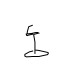

In [12]:
draw_strokes(flops.strokes[1004], factor=0.2)

here's a random owl with 28 strokes and ppx=-0.174484804273


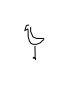

In [13]:
def complete_fowl(fowl, temperature=1.0):
    global sample_model, hps, sess, model, eval_model, conditional
    # cut the last stroke with the 'end of sketch' state
    # TODO: should keep dx and dy and just change the state
    fowl = fowl[:-1]
    if conditional:
        zowl = nbhelpers.encode(fowl, eval_model, sess)
        zowl = [zowl]
    else:
        zowl = None
    superb_owl = transfig.sample_completions(
        sess, sample_model, fowl,
        seq_len=hps.max_seq_len, # use default hps max seq len - it's set to 1 for sample model hps
        temperature=temperature,
        z=zowl
    )
    return superb_owl

fowl = dataset.strokes[0]
print "here's a random owl with {} strokes and ppx={}".format(
    len(fowl), df.iloc[0]['ppx']
)
draw_strokes(fowl)

completion went to 94 strokes


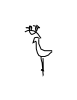

In [14]:
finefowl = complete_fowl(fowl)
fine3 = utils.to_normal_strokes(finefowl)
print "completion went to {} strokes".format(len(fine3))
draw_strokes(fine3)

In [15]:
def batch_superb(n, temperature=1.0, dataset=dataset, factor=0.1):
    grid = []
    for i in range(n):
        fowl = dataset.strokes[i]
        grid.append([fowl, [i, 0]])
        #origstrokes = len(fowl)
        superbowl = complete_fowl(fowl, temperature)
        grid.append([utils.to_normal_strokes(superbowl), [i, 1]])
    strokes = make_grid_svg(grid, grid_space=13.0, grid_space_x=18)
    draw_strokes(strokes, factor=factor)

In [ ]:
batch_superb(30, temperature=1, dataset=flops, factor=0.07)

In [ ]:
batch_superb(30, temperature=0.3, dataset=flops, factor=0.07)

In [ ]:
batch_superb(10, temperature=0.01)

In [ ]:
batch_superb(50, temperature=1.0)

In [ ]:
batch_superb(50, temperature=1.5)

In [97]:
rows = 20
cols = 8
draw_kwargs = dict(n=rows*cols, rows=rows)
strokes = dataset.strokes


In [ ]:
# TODO: surprisingly slow?
randixs = draw_top_n(ppx, strokes, random=1,
                     fname='svgs/{}_random.svg'.format(domain),
                     **draw_kwargs);

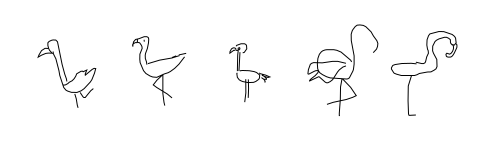

In [104]:
nice_rands = [
    (3,8), (3,3), (4,5), (13,2), (17,6)
]
nice_indices = []
for n, (x, y) in enumerate(nice_rands):
    i = ((x-1)*cols)+(y-1)
    nice_indices.append(randixs[i])
    #sk = strokes[randixs[i]]
    #draw_strokes(sk, svg_filename='svgs/flamingo_nice_{}.svg'.format(n))
draw_sketches(strokes, nice_indices, fname='svgs/nice_flamingos.svg', grid_space=14, grid_space_x=18)

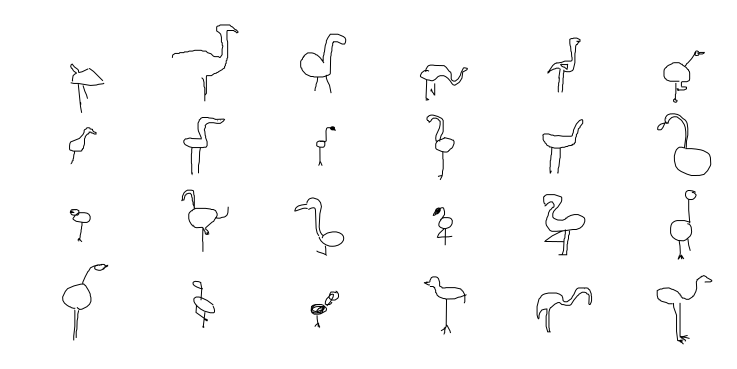

In [303]:
rows = 4
cols = 6
draw_kwargs = dict(n=rows*cols, rows=rows)
ixs = draw_top_n(ppx, strokes, 
                 #prefix='{}_top'.format(domain),
                 #fname='svgs/{}_best.svg'.format(domain),
                 **draw_kwargs);

In [289]:
botargs = draw_kwargs.copy()
rows = 40
cols = 10
botargs['rows'] = rows
botargs['n'] = cols*rows
nbotixs = draw_top_n(ppxnorm, strokes, sign=-1, grid_space=30, grid_space_x=45, 
                    factor=0.1,
                    prefix='{}_bottom_ppxnorm'.format(domain),
                    #fname='svgs/{}_bottom_ppx.svg'.format(domain),
                    echo=0,
                    save=1,
                    size=(300,300),
                    **botargs);

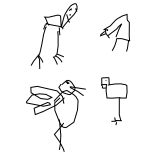

In [331]:
#def draw_sketches(strokes, indices, rows=1, cols=None, grid_space=16.0, grid_space_x=24.0, fname='',echo=True):
specials = [109049, 37929, 107804, 23735] #65950]
draw_sketches(strokes, specials, rows=2, fname='svgs/special.svg',
              grid_space=13.0, grid_space_x=12.0,
              pady=3,
             )

In [166]:


# 17 = good example of flamingo + scribble
badcats = dict(
    # 105, 107, 195, 46, 172,
    awful=[31, 38, 44, 54, 55, 57, 59, 61, 65, 
           75, 76, 79, 91, 99, 100, 102, 115, 120, 
           134, 141, 145, 168, 180, 196, 296, 339, 
           345, 432],
    # 7
    scribbles=[0, 1, 2, 3, 4, 5, 6, 9, 12, 13, 14, 17],
    cheat=[26, 37, 119, 161, 169, 193, 194, 204, 220, 254, 257, 268, 352, 412, 483, 548],
    wtf=[8, 35, 68, 82, 87, 71, 72, 103, 109, 111, 113, 121, 143, 157,
        163, 181, 192, 206, 235, 310, 341, 359, 386, 387],
    graffiti=[16, 88, 208, 225, 228, 234, 258, 283, 314, 402, 558],
    otherthings=[282, 317, 408, 518, 536, 96, 43,],
    # 154 = audobon
    # 48, 49, 64, 90, 101, 94
    notbad=[259, 300, 348, 154],
)

for (cat, indices) in badcats.items():
    for rank, i in enumerate(indices):
        path = 'svgs/bottom/{}/{}.svg'.format(cat, rank)
        nbhelpers.draw_strokes(strokes[botixs.iloc[i]],
                     svg_filename=path,
                     factor=0.125,
                     echo=False,
                     size=(300,300),
                     stroke_width=1.5
                    )

for (cat, indices) in badcats.items():
    gspace_lookup = {'graffiti': [20, 30]}
    gspace_default = [30, 45]
    gsy, gsx = gspace_lookup.get(cat, gspace_default)
    draw_sketches(strokes, botixs.iloc[indices],
                  cols=4,
                  grid_space=gsy, grid_space_x=gsx,
                  fname='svgs/botflamingos_{}.svg'.format(cat),
                  echo=False,
                 )

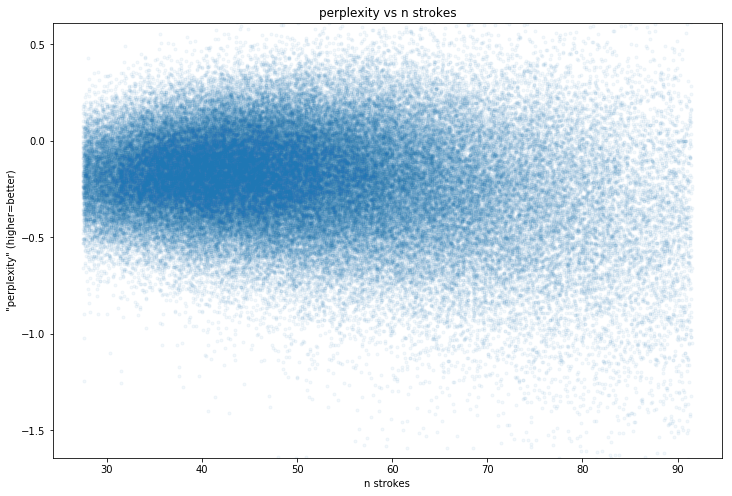

In [268]:
%matplotlib inline
FS = (12, 8)
fig, ax = plt.subplots(figsize=FS)
xnoise = (np.random.rand(len(df)) - .5)
ax.plot(df['len'] + xnoise, 
        df['ppx'], 
        '.',
        alpha=.05
       )
ax.set_yscale('linear')
ax.set_ylim(
    bottom=df['ppx'].quantile(.001),
    top=df['ppx'].quantile(.999)
)
ax.set_ylabel('"perplexity" (higher=better)')
ax.set_title('perplexity vs n strokes')
ax.set_xlabel('n strokes');

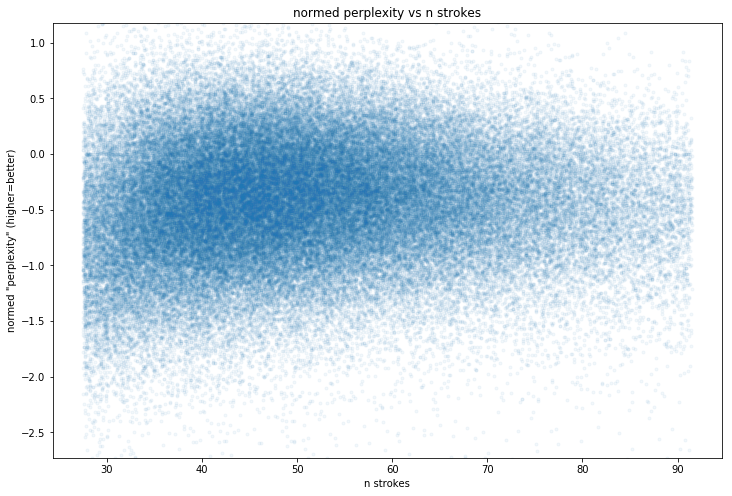

In [269]:
%matplotlib inline
FS = (12, 8)
fig, ax = plt.subplots(figsize=FS)
xnoise = (np.random.rand(len(df)) - .5)
ax.plot(df['len'] + xnoise, 
        df['ppxnorm'], 
        '.',
        alpha=.05
       )
ax.set_yscale('linear')
ax.set_ylim(
    bottom=df['ppxnorm'].quantile(.001),
    top=df['ppxnorm'].quantile(.999)
)
ax.set_ylabel('normed "perplexity" (higher=better)')
ax.set_title('normed perplexity vs n strokes')
ax.set_xlabel('n strokes');

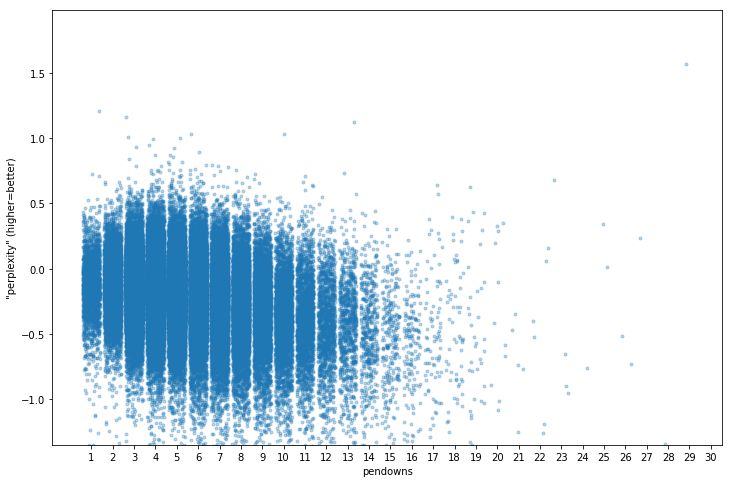

In [93]:
xmax=30
fig, ax = plt.subplots(figsize=FS)
masked = df[df['pendowns'] <= xmax]
xnoise = (np.random.rand(len(masked)) - .5) * .8
ax.plot(masked['pendowns'] + xnoise, 
        masked['ppx'], 
        '.',
        alpha=.3
       )
ax.set_yscale('linear')
#ax.set_xscale('log')
ax.set_ylim(bottom=df['ppx'].quantile(.0025))
ax.set_ylabel('"perplexity" (higher=better)')
ax.set_xticks(range(1, xmax+1))
ax.set_xlabel('pendowns');

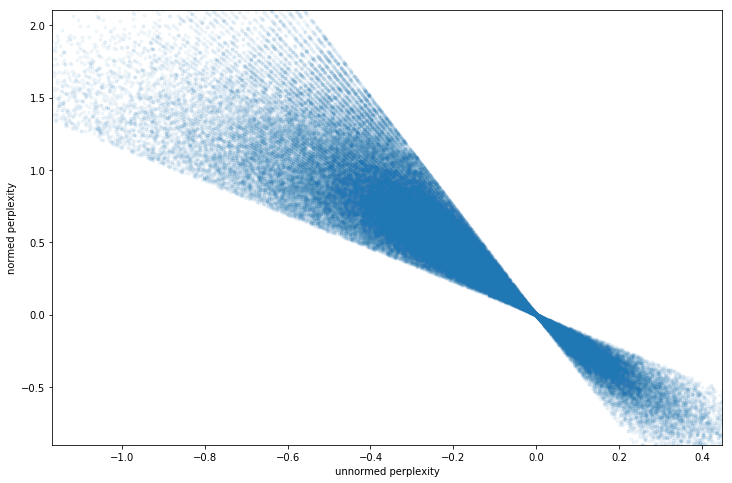

In [186]:
FS = (12, 8)
fig, ax = plt.subplots(figsize=FS)
ax.plot(df['ppx'],
        df['ppxnorm'], 
        '.',
        alpha=.05
       )
ax.set_yscale('linear')
if 1:
    topquant = .995
    botquant = .005
    ax.set_xlim(
        left=df['ppx'].quantile(botquant),
        right=df['ppx'].quantile(topquant)
    )
    ax.set_ylim(
        bottom=df['ppxnorm'].quantile(botquant),
        top=df['ppxnorm'].quantile(topquant)
    )
ax.set_ylabel('normed perplexity')
ax.set_title('')
ax.set_xlabel('unnormed perplexity');

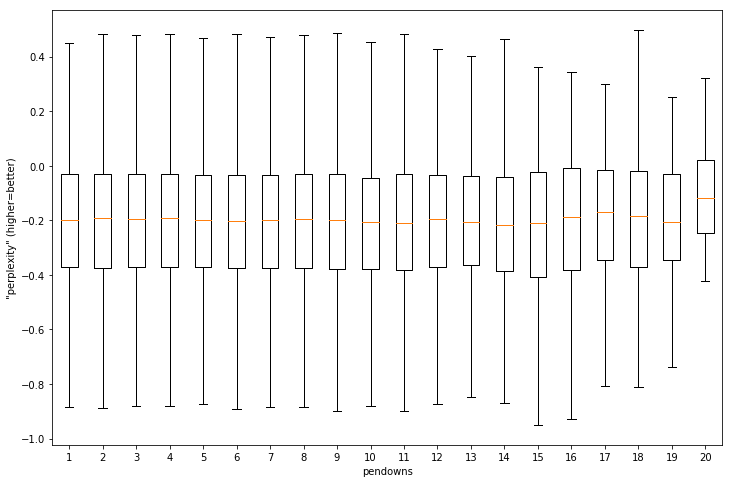

In [26]:
fig, ax = plt.subplots(figsize=FS)
perpendown = df['pendowns'].value_counts().sort_index()
penvals = perpendown[perpendown >= 10].index
penvecs = [
    df[df['pendowns']==pend]['ppx'].dropna() for pend in penvals
]
ax.boxplot(penvecs, 
           labels=penvals,
           sym='',
          );
ax.set_ylabel('"perplexity" (higher=better)')
ax.set_xlabel('pendowns');

In [27]:
def describe(arr):
    s = pd.Series(arr)
    print s.describe([]).to_frame().T

label_to_ixs = dict(random=randixs, top=ixs, bottom=botixs)
for label, ixs in label_to_ixs.items():
    print "{} sketches...".format(label)
    these_ppxs = ppx[ixs]
    print "**ppx"
    describe(these_ppxs)
    nstrokes = [len(dataset.strokes[i]) for i in ixs]
    print "**n strokes"
    describe(nstrokes)
    print
    
# Worst sketches have more lines. Maybe this makes sense because if they were a good
# drawer, the ai would have guessed what they were drawing earlier. (When you're struggling
# to draw "pool" with 5 seconds left on the timer, you may find yourself frantically adding pointless
# extra lines in desperation. Maybe it just needs a ladder? Or some bubbles? Yeah, I've been there.)

top sketches...
**ppx
     count      mean       std       min       50%       max
ppx  106.0  0.741361  0.148405  0.622012  0.691689  1.569276
**n strokes
   count      mean        std   min   50%   max
0  160.0  58.40625  20.292297  28.0  64.0  91.0

random sketches...
**ppx
     count     mean       std       min       50%       max
ppx  160.0 -0.22101  0.276385 -1.479754 -0.199886  0.451744
**n strokes
   count      mean        std   min   50%   max
0  160.0  51.11875  13.867464  28.0  49.5  90.0

bottom sketches...
**ppx
     count      mean       std       min       50%       max
ppx  160.0 -2.050957  0.747174 -6.678692 -1.800074 -1.513045
**n strokes
   count     mean        std   min   50%   max
0  160.0  75.1375  12.343352  28.0  77.0  91.0



In [168]:
# Look at top/bottom 10 perplexities
print ppx[np.argpartition(ppx, 10)[::-1][-10:]]
print ppx[np.argpartition(ppx, -10)[::1][-10:]]

ppx
96048    -3.140309
110770   -3.509122
101821   -3.576904
112281   -5.222753
111787   -6.678692
109737   -3.580858
97336    -6.065960
80659    -3.711041
101877   -3.626338
111637   -3.593515
Name: ppx, dtype: float64
ppx
99422     0.950770
108209    0.995214
94339     1.002656
105133    1.209887
109775    1.032398
104476    1.158852
73375     1.009133
110256    1.124669
107228    1.034216
108735    1.569276
Name: ppx, dtype: float64


In [29]:
print "Got {} nan perplexities out of {}".format(np.isnan(ppx).sum(), ppx.shape[0])

Got 54 nan perplexities out of 112708


count    112708.000000
mean         51.266769
std          14.349400
min          28.000000
25%          40.000000
50%          49.000000
75%          60.000000
max          91.000000
Name: len, dtype: float64


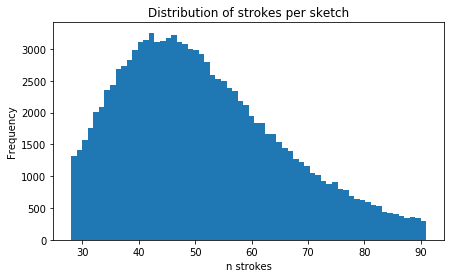

In [297]:
sls = df['len']
print sls.describe()

fig, ax = plt.subplots(figsize=(7,4))

# Distribution of n strokes
sls.plot.hist(ax=ax, bins=sls.max()-sls.min()+1)
ax.set_xlabel('n strokes')
ax.set_title('Distribution of strokes per sketch');
fig.savefig('nstrokes.png')

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(8,5))
df['pendowns'].plot.hist(bins=17, ax=ax);

In [ ]:
assert False

In [ ]:
# Sorting along individual dimensions
reload(ds)
import dimsort as ds
sample = [dataset.strokes[randi] for randi in randixs]
# Get latent vectors for a random subset of owls
zs = ds.batch_zs(sample, eval_model, sess)

In [ ]:
ds.sort_and_draw(0, sample, zs)

In [ ]:
ds.sort_and_draw(1, sample, zs)

In [ ]:
ds.sort_and_draw(2, sample, zs)

In [105]:
def encode(input_strokes):
  """Return the latent vector z for given drawing (and also draw it as a side effect)
  """
  strokes = utils.to_big_strokes(input_strokes,
                           max_len=model.hps.max_seq_len
                          ).tolist()
  strokes.insert(0, [0, 0, 1, 0, 0])
  seq_len = [len(input_strokes)]
  draw_strokes(utils.to_normal_strokes(np.array(strokes)))
  return sess.run(eval_model.batch_z, feed_dict={eval_model.input_data: [strokes], eval_model.sequence_lengths: seq_len})[0]


def decode(z_input=None, draw_mode=True, temperature=.3, factor=0.2):
  z = None
  if z_input is not None:
    z = [z_input]
  sample_strokes, m = models.sample(sess, sample_model, seq_len=eval_model.hps.max_seq_len, temperature=temperature, z=z)
  strokes = utils.to_normal_strokes(sample_strokes)
  if draw_mode:
    draw_strokes(strokes, factor)
  return strokes

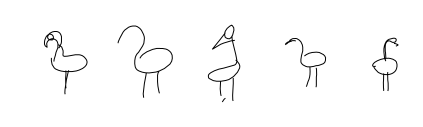

In [106]:
# randomly unconditionally generate 10 examples
N = 5
reconstructions = []
for i in range(N):
  reconstructions.append([decode(temperature=0.5, draw_mode=False), [0, i]])
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

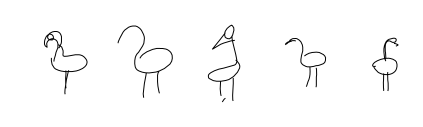

In [108]:
draw_strokes(stroke_grid, 
  svg_filename='/home/colin/src/colinmorris.github.com/assets/quickdraw/svgs/generated_flamingos.svg'
)

In [ ]:
hoot = dataset.strokes[randixs[4]]
draw_strokes(hoot)

In [ ]:
z = encode(hoot)

In [ ]:
decodings = [decode(z) for _ in range(5)]

In [ ]:
zmut = z.copy()
zmut[45] = 2
decodingsm = [decode(z) for _ in range(5)]

In [ ]:
face = dataset.strokes[randixs[7]]
zface = encode(face)

In [ ]:
decodingsf = [decode(zface, temperature=0.2) for _ in range(5)]

In [ ]:
z_list = [] # interpolate spherically between z_0 and z_1
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(utils.slerp(z, zface, t))
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], draw_mode=False, temperature=0.1), [0, i]])
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

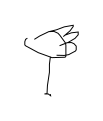

In [61]:
draw_strokes(rawdat[97336], factor=5)

In [59]:
df.loc[botixs]

,len,ppx,pendowns
111787,60,-6.678692,9
97336,49,-6.065960,3
112281,64,-5.222753,6
80659,41,-3.711041,3
101877,62,-3.626338,3
111637,32,-3.593515,3
109737,42,-3.580858,4
101821,71,-3.576904,6
110770,58,-3.509122,10
96048,51,-3.140309,4
